In [2]:
from scipy.special import roots_jacobi, eval_jacobi
import numpy as np
import scipy
import math

In [3]:
import matplotlib.pyplot as plt

### Initialization:

In [43]:
L = 12 # Denotes total length in [0, L]
M = 4 # Denotes number of elements 
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints

In [44]:
x_range

array([ 0.,  3.,  6.,  9., 12.])

In [5]:
def int_points(x_range, npts, dx, M):
    
    k = 0
    p_order = npts - 1
    xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
    GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))
    GLL_dist = np.array([np.abs(GLL_points[0] - value) for value in GLL_points])
    
    return_array = np.zeros([M, npts])
    
    for i in x_range[:-1]:
        array = np.array([i])
        for j in GLL_dist[1:]: 
            scaled_point = ((j / 2) * (dx)) + i # Note: 2 here is the distance from -1 to 1
            array = np.concatenate((array, np.array([scaled_point])))
            
        return_array[k, :] = array
        k = k + 1
    
    return(return_array)

In [6]:
def init_Guassian(input_array, mu, sigma): 
    
    return_array = np.zeros_like(input_array)
    
    for i in np.arange(input_array.shape[0]):
        
        numerator = np.exp(-(input_array[i] - mu)**2 / (2 * sigma**2))
        denominator = sigma * np.sqrt(2 * np.pi)
        return_array[i, :] = numerator / denominator 
        
    return(return_array)

In [7]:
def Guassian_1st_deriv(input_array, mu, sigma):
    return(-(input_array - mu) / sigma**2 * init_Guassian(input_array, mu, sigma))

## Apply Derivative Operator to Elements:

In [8]:
def vandermonde(npts_values, return_type):
    # For the monomial basis: 
    if return_type == 'Monomial':
        return(np.vander(npts_values, increasing = True))
    elif return_type == 'Legendre':
        return(np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1))

In [9]:
def Ld_vandermonde(npts_values): 
    
    LP = np.polynomial.legendre
    v_matrix = np.polynomial.legendre.legvander(npts_values, len(npts_values)-1)
    d_v_matrix = np.zeros_like(v_matrix)

    for i in range(len(npts_values)):
        # Coefficients for the i-th Legendre polynomial (e.g., [0, 0, 1] for P_2)
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = 1

        # Compute the derivative of the i-th Legendre polynomial
        deriv_coeffs = LP.legder(coeffs, m=1) # m=1 for first derivative

        # Evaluate the derivative at the points x
        d_v_matrix[:, i] = LP.legval(npts_values, deriv_coeffs)
        
    return(d_v_matrix)

In [10]:
def Md_vandermonde(npts_values):
    
    v_matrix = np.vander(npts_values, increasing = True)
    d_v_matrix = np.zeros_like(v_matrix)
    
    for i in range(len(npts_values) - 1):
        coeffs = np.zeros(len(npts_values))
        coeffs[i] = i + 1
        
        deriv_P = np.polynomial.polynomial.Polynomial(coeffs) 
        d_v_matrix[:, i + 1] = deriv_P(npts_values)
        
    return(d_v_matrix)

In [11]:
def return_D(V1, V2):
    return(np.matmul(V2, np.linalg.inv(V1)))

### Compute Derivative Matrix:

In [12]:
# Note: the nodal inputs are all within the reference element:

npts = 4
p_order = npts - 1
xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))

V1 = vandermonde(GLL_points, 'Legendre')
V2 = Ld_vandermonde(GLL_points)
D = return_D(V1, V2)

In [13]:
# Note: L, M are constants; D denotes the derivative matrix computed above:

def deriv_elements(D, value_array, L, M):
    
    return_array = np.zeros_like(value_array)
    
    for i in np.arange(M): 
        d_values = np.matmul(D, value_array[i].transpose())
        return_array[i] = (d_values * ((2 * M) / L)) # Multiply by factor: (2M / L)
        
    return(return_array)

In [15]:
deriv_values = deriv_elements(D, init_Guassian(int_points(x_range, 4, L/M, M), (L/2), 1), 
                              L, M)

deriv_values

array([[ 4.80309656e-05, -2.72883810e-05,  1.08112058e-04,
         3.50795551e-04],
       [ 7.13302624e-03,  3.58136840e-04,  4.25489230e-02,
         1.01474492e-01],
       [ 7.47239811e-02,  2.15874692e-01,  1.82916599e-01,
         1.02744572e-03],
       [-1.02744572e-03, -1.82916599e-01, -2.15874692e-01,
        -7.47239811e-02],
       [-1.01474492e-01, -4.25489230e-02, -3.58136840e-04,
        -7.13302624e-03],
       [-3.50795551e-04, -1.08112058e-04,  2.72883810e-05,
        -4.80309656e-05]])

### Quick Plotting:

In [29]:
def plot_FEM(int_points, value_array, M):
    
    fig = plt.plot()
    
    for i in np.arange(M):
        plt.plot(int_points[i], value_array[i], marker = 'o')
        # plt.plot(fine_int_points[i], fine_value_array[i])

    return()

def plot_FEM_ic(int_points, value_array, M):
     
    for i in np.arange(M):
        plt.plot(int_points[i], value_array[i], marker = '*', color = 'green')
        # plt.plot(fine_int_points[i], fine_value_array[i])

    return()

[]

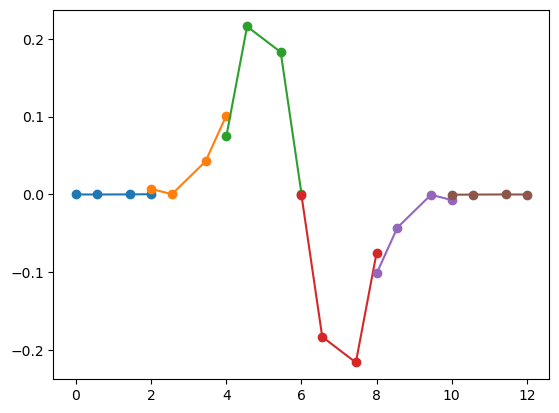

In [17]:
plot_FEM(int_points(x_range, 4, L/M, M), deriv_values, M)
         # int_points(x_range, 25, L/M, M), Guassian_1st_deriv(int_points(x_range, 25, L/M, M), (L/2), 1))


In [173]:
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints

In [174]:
# Note: The num_pts variable is for each element; written for Legendre basis
def dV_multi_finegrid(x_range, n_order, num_pts, deriv_values):
    
    hold = 0
    LP = np.polynomial.legendre
    dv_finegrid = np.zeros([num_pts * (len(x_range) - 1), n_order])
    
    for i, j in enumerate(x_range[:-1]):
        # dx = np.diff(x_range)[0] / (num_pts) # Assuming element lengths are all equal 
        dx = (1/5)
        npts = np.arange(j, x_range[i+1], dx)
     
        for k in np.arange(n_order):
            coeffs = np.zeros(n_order)
            coeffs[k] = 1
            
            deriv_coeffs = LP.legder(coeffs, m=1)
        
            # We need to calculate (LP'(x) * LP^-1(x)): 
            d_P = LP.legval(npts, deriv_coeffs)
            P = np.polynomial.legendre.Legendre(coeffs)
            
            dv_finegrid[hold : hold + (num_pts), k] = (d_P / P(npts))
            
        hold = hold + num_pts
        
    return(dv_finegrid)

In [ ]:
dV_multi_finegrid(x_range, 4, 10, deriv_values)

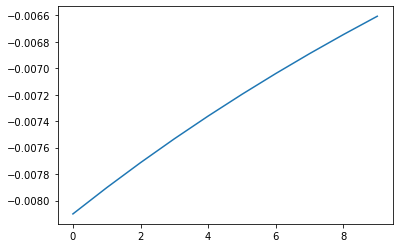

In [145]:
plt.plot(np.arange(0, 10), np.matmul(elem_4, deriv_values[4].transpose()))

### CG Boundary Averaging:

In [18]:
def boundary_mean(value_array, M):
    
    return_array = value_array.copy()
     
    for i in np.arange(M-1):
        mean_value = np.mean([value_array[i][-1], value_array[i+1][0]])
        return_array[i][-1] = mean_value
        return_array[i+1][0] = mean_value 
        
    # For the endpoints:
    return_array[-1][-1] = np.mean([value_array[-1][-1], value_array[0][0]])
    return_array[0][0] = np.mean([value_array[-1][-1], value_array[0][0]])
        
    return(return_array)

In [19]:
test = boundary_mean(deriv_values, M)

[]

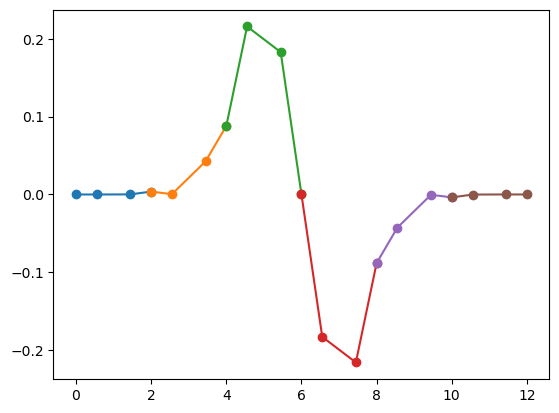

In [20]:
plot_FEM(int_points(x_range, 4, L/M, M), test, M)
         # int_points(x_range, 25, L/M, M), Guassian_1st_deriv(int_points(x_range, 25, L/M, M), (L/2), 1))

### Applied to 1D Advection (with Predictor-Corrector Method):

In [45]:
# Initialize the elements and the Guassian function:
L = 12 # Denotes total length in [0, L]
M = 4 # Denotes number of elements 
x_range = np.arange(0, L + (L/M), (L/M)) # Define the element endpoints

npts = int_points(x_range, 4, L/M, M)

In [49]:
# Compute the derivative matrix:
def SEM_dx(D, u, M, L):
    
    u_out = np.zeros_like(u)
    
    for j in np.arange(npts.shape[0]):
        u_out[j] = (np.matmul(D, u[j].transpose()) * ((2 * M) / L))
        
    return(boundary_mean(u_out, u_out.shape[0]))

In [50]:
t_steps = 24
CFL = 0.10
dt = 0.10

u = init_Guassian(npts, (L/2), 1)

for i in np.arange(0, t_steps, dt):
    
    u_mid = np.zeros_like(u)
    u_n = np.zeros_like(u)
    
    # Half time step:
    u_mid = u - ((dt / 2) * SEM_dx(D, u, M, L))
    # Full time step:
    u_n = u - ((dt) * SEM_dx(D, u_mid, M, L))
    
    # Prepare for the next timestep:
    u = u_n

In [52]:
u

array([[-0.00657666,  0.02795147,  0.01076844, -0.0009543 ],
       [-0.0009543 ,  0.02187938,  0.27446811,  0.40223043],
       [ 0.40223043,  0.28547393,  0.05898083,  0.01534053],
       [ 0.01534053, -0.01199169, -0.02650559, -0.00657666]])

IndexError: index 4 is out of bounds for axis 0 with size 4

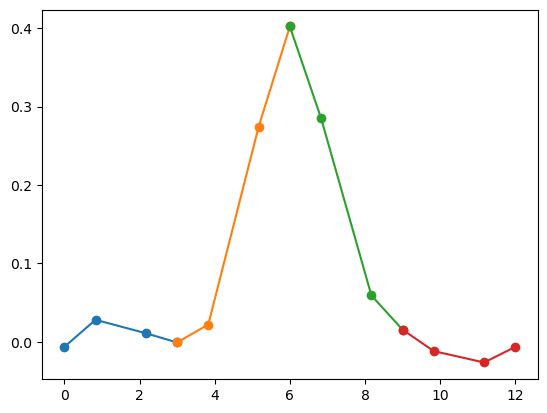

In [51]:
plot_FEM(npts, u, 6)
plot_FEM_ic(npts, init_Guassian(npts, (L/2), 1), 6)
plt.title('IC & FEM Solution at t_step: 36')

### Property Check -> Integration by Parts:

In [340]:
# Note: Quad weights only needs to defined for one element as all elements use the same functional space
# The weights are calculated using exact integration 

def quad_weights(npts_values):
    
    # Values in f_array result from exact integration:
    f_array = np.zeros(len(npts_values))
    f_array[0] = 2
    
    # Define basis matrix for Legendre polynomials: 
    V = np.polynomial.legendre.legvander(npts_values, len(npts_values) - 1).transpose()
    
    return(np.matmul(np.linalg.inv(V), f_array.transpose()))

In [ ]:
def quad_int(): 

In [344]:
p_order = 3
xinterior, w = roots_jacobi(p_order - 1,1,1) # returns interior GLL nodes from range -1 and 1
GLL_points = np.pad(xinterior, (1, 1), 'constant', constant_values=(-1, 1))

quad_weights(GLL_points)

array([0.16666667, 0.83333333, 0.83333333, 0.16666667])